In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits, ascii
from astropy.table import Table
from astropy.modeling import models, fitting
from photutils import RectangularAperture, aperture_photometry
import glob, pdb, mpld3
from mpld3 import plugins
from scipy.optimize import curve_fit

plt.rcParams['figure.figsize'] = (12, 6)
mpld3.enable_notebook()

In [2]:
fnames = np.sort(glob.glob('../hst_archive/*_flt.fits'))
len(fnames)

396

In [36]:
img_list = []
hdr_list = []
ind = []
for i, fn in enumerate(fnames):
    hdu = fits.open(fn)
    header = hdu[0].header
    if header['OBSTYPE'] == 'SPECTROSCOPIC':
        ind.append(i)
        image = hdu[1].data
        img_list.append(image)
        hdr_list.append(header)
    hdu.close()
len(img_list)
# ascii.write(fnames[ind].reshape((392,1)), 'spec_filenames.csv', overwrite = True)

392

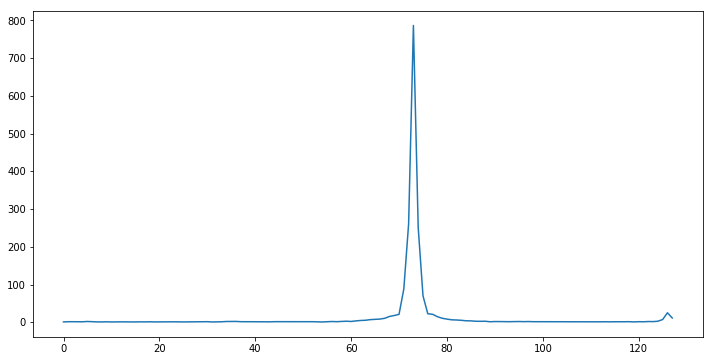

In [5]:
plt.plot(img_list[20][:, 64])

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
      amplitude        mean         stddev    
    ------------- ------------- --------------
    781.162044753 72.9903055426 0.682920881808


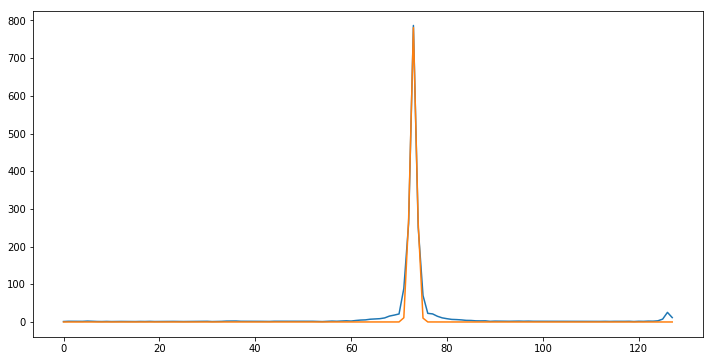

In [6]:
# Fitting gaussian to a column of the spectrum (x=65)

im = img_list[20]
x = range(im.shape[0])
y = im[:, 64]

g_init = models.Gaussian1D(amplitude=760., mean=75., stddev=1.)
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, x, y)
print(g)

plt.plot(x, y)
plt.plot(x, g(x))

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
      amplitude        mean         stddev    
    ------------- ------------- --------------
    75110.0495283 72.9425734015 0.842034094733


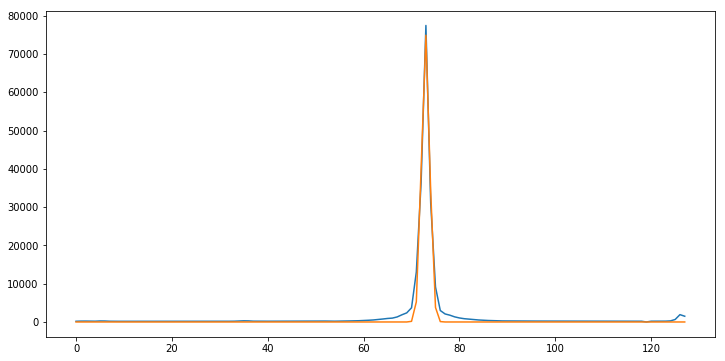

In [7]:
collapsing_spectrum = np.sum(im, axis = 1)

g_init = models.Gaussian1D(amplitude=76000., mean=75., stddev=1.)
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, x, collapsing_spectrum)
print(g)

plt.plot(x, collapsing_spectrum)
plt.plot(x, g(x))

Applying centering to every image

In [40]:
centers = []
for im in img_list:
    x      = range(im.shape[0])
    y      = np.sum(im, axis = 1)
    g_init = models.Gaussian1D(amplitude=760., mean=75., stddev=1.)
    fit_g  = fitting.LevMarLSQFitter()
    g      = fit_g(g_init, x, y)
    y_cen  = g.mean[0]
    x_cen  = im.shape[0]/2
    centers.append([x_cen, y_cen])
centers = np.array(centers)
# ascii.write(centers, 'centers.csv', comment = 'center for all visits according to the ordering of spec_filenames.scv',
#             overwrite = True)

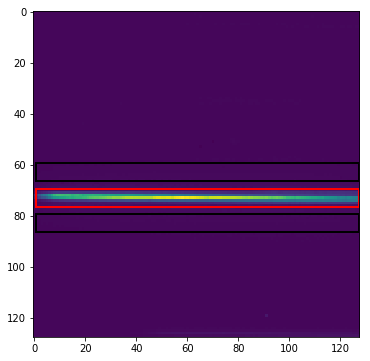

In [9]:
plt.imshow(img_list[10])
src_ap = RectangularAperture(centers[10], w = 127, h = 7, theta = 0.0)
bk_ap1 = RectangularAperture((centers[10][0], centers[10][1] + 10), w = 127, h = 7, theta = 0.0)
bk_ap2 = RectangularAperture((centers[10][0], centers[10][1] - 10), w = 127, h = 7, theta = 0.0)
src_ap.plot(color = 'r', linewidth = 2)
bk_ap1.plot(color = 'k', linewidth = 2)
bk_ap2.plot(color = 'k', linewidth = 2)

In [38]:
flux_table = Table(names = ('time', 'raw_flux', 'bkg_flux', 'res_flux', 'position angle'))
for i, (image, header) in enumerate(zip(img_list, hdr_list)):
    
    src_ap = RectangularAperture(centers[i], w = 127, h = 7, theta = 0.0)
    bk_ap1 = RectangularAperture((centers[i][0], centers[i][1] + 10), w = 127, h = 8, theta = 0.0)
    bk_ap2 = RectangularAperture((centers[i][0], centers[i][1] - 10), w = 127, h = 8, theta = 0.0)
    
    mask     = np.isnan(image) == True
    time     = header['EXPSTART']
    raw_flux = aperture_photometry(image, src_ap, mask = mask)['aperture_sum']
    
    bkg1 = aperture_photometry(image, bk_ap1, mask = mask)['aperture_sum']
    bkg_mean1 = bkg1/bk_ap1.area()
    bkg_flux1 = bkg_mean1*src_ap.area()
    bkg2 = aperture_photometry(image, bk_ap2, mask = mask)['aperture_sum']
    bkg_mean2 = bkg2/bk_ap2.area()
    bkg_flux2 = bkg_mean2*src_ap.area()
    bkg_flux = (bkg_flux1 + bkg_flux2)/2
    
    res_flux = raw_flux - bkg_flux
    
    #pointing information
    pa = header['PA_V3']
    
    flux_table.add_row([time, raw_flux, bkg_flux, res_flux, pa])
flux_table

time,raw_flux,bkg_flux,res_flux,position angle
float64,float64,float64,float64,float64
55949.9071568,171969.087127,5036.78403736,166932.30309,224.535599
55949.9085338,172764.519041,4959.52332172,167804.99572,224.535599
55949.9099112,173012.401936,4853.67718433,168158.724752,224.535599
55949.9112886,173133.565762,4810.17844575,168323.387317,224.535599
55949.912666,173349.19579,4805.85773487,168543.338055,224.535599
55949.9140431,173423.833174,4790.17765862,168633.655516,224.535599
55949.9154205,173450.280743,4775.79871062,168674.482032,224.535599
55949.9167979,173559.602203,4772.02942668,168787.572776,224.535599
55949.9181753,173468.795891,4770.4826789,168698.313212,224.535599


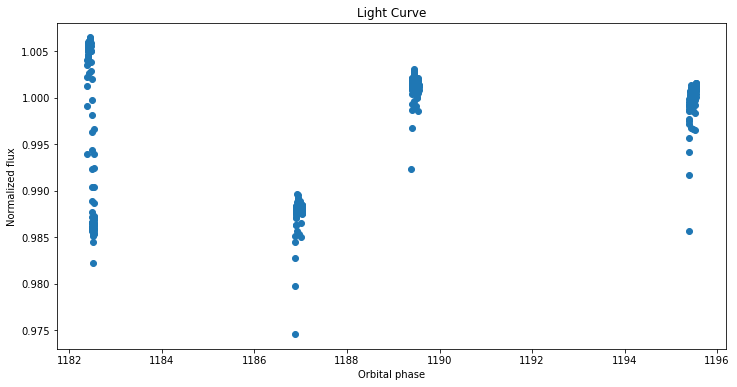

In [39]:
tt        = 2454159.45320
period    = 1.5089557
jd_const  = 2400000.5
norm_flux = flux_table['res_flux']/np.median(flux_table['res_flux'])
op        = np.sort((flux_table['time'] + jd_const - tt)/period)
ind       = np.argsort(flux_table['time'])

fig, ax = plt.subplots()
points  = ax.plot(op, norm_flux, 'o')
ax.set_xlabel('Orbital phase')
ax.set_ylabel('Normalized flux')
ax.set_title('Light Curve')

# fig.savefig('Light_Curve.pdf')
plugins.connect(fig, plugins.MousePosition(fontsize=14))
labels = ['{}, {}'.format(i + 1, pa) for i, pa in zip(range(len(op)), flux_table['position angle'][ind])]
tooltip = mpld3.plugins.PointLabelTooltip(points[0], labels=labels)
plugins.connect(fig, tooltip)